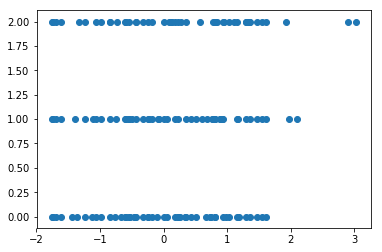

In [4]:
# -*- coding: utf-8 -*-
import numpy as np
import ot
import matplotlib.pyplot as plt
import math
def myarray_sum(x,v):
    """
    Examples
    --------
    >>> import numpy as np
    >>> abc = np.array(np.arange(2*3*4)).reshape((2,3,4))
    >>> print(myarray_sum(abc,np.array([0])))
    >>> print(myarray_sum(abc,np.array([0,1])))
    >>> print(myarray_sum(abc,np.array([0,2])))
    >>> print(myarray_sum(abc,np.array([1])))
    """
    ret = x
    for i in range(v.size):
        ret = ret.sum(v[i]-i)  #axisを指定、結果的にvで指定した列をなくす
    return ret

def sinkhorn3d(a,b,c, M, reg, numItermax = 1000, stopThr=1e-9, verbose=False, log=False):
  a=np.asarray(a,dtype=np.float64)   #a,b,cには細胞の重み付けを入れる
  b=np.asarray(b,dtype=np.float64)
  c=np.asarray(c,dtype=np.float64)
  M=np.asarray(M,dtype=np.float64)
  
  if len(a)==0:
      a=np.ones((M.shape[0],),dtype=np.float64)/M.shape[0]
  if len(b)==0:
      b=np.ones((M.shape[1],),dtype=np.float64)/M.shape[1]
  if len(c)==0:
      c=np.ones((M.shape[2],),dtype=np.float64)/M.shape[2]
  
  # init data
  Nini = len(a)
  Nfin = len(b)
  Nfon = len(c)
  
  
  cpt = 0
  
  if log:
      log={'err':[]} #log=Trueならlogを出力
  
  # we assume that no distances are null except those of the diagonal of distances
  #u,v,wの初期値
  u = np.ones(Nini)/Nini
  v = np.ones(Nfin)/Nfin
  w = np.ones(Nfon)/Nfon
  
  #uprev=np.zeros(Nini)
  #vprev=np.zeros(Nfin)
  #wprev=np.zeros(Nfon)
  uprev = u
  vprev = v
  wprev = w
  
  #print reg
  
  K = np.exp(-M/reg)
  #print np.min(K)
  
  #Kp = np.dot(np.diag(1/a),K)
  transp = K
  cpt = 0
  err=1
  while (err>stopThr and cpt<numItermax):
      tmp = np.meshgrid(u,v,w,indexing='ij')
      #print(tmp)
      slicesumv = myarray_sum(K*tmp[0]*tmp[2],np.array([0,2])) #vを残して和でおしつぶす
      slicesumw = myarray_sum(K*tmp[0]*tmp[1],np.array([0,1]))
      slicesumu = myarray_sum(K*tmp[1]*tmp[2],np.array([1,2]))
      #print(sum(slicesumv))
      #print(slicesumv)
      #if np.any(np.dot(K.T,u)==0) or np.any(np.isnan(u)) or np.any(np.isnan(v)) or np.any(np.isnan(w)):
      if np.any(slicesumv==0) or np.any(slicesumw==0) or np.any(slicesumu==0) or np.any(np.isnan(u)) or np.any(np.isnan(v)) or np.any(np.isnan(w)):
          # we have reached the machine precision
          # come back to previous solution and quit loop
          print('Warning: numerical errrors')
          if cpt!=0:
              u = uprev
              v = vprev
              w = wprev
          break
      uprev = u
      vprev = v
      wprev = w
      #v = np.divide(b,np.dot(K.T,u))
      #u = 1./np.dot(Kp,v)
      #u = np.divide(a,np.dot(K,v))
      #w = np.divide(c,np.dot(K,u))
      
      v = np.divide(b,slicesumv) #対応する要素の商をとる
      tmp = np.meshgrid(u,v,w,indexing='ij')
      slicesumw = myarray_sum(K*tmp[0]*tmp[1],np.array([0,1]))
      w = np.divide(c,slicesumw)
      tmp = np.meshgrid(u,v,w,indexing='ij')
      slicesumu = myarray_sum(K*tmp[1]*tmp[2],np.array([1,2]))
      u = np.divide(a,slicesumu)
      if cpt%10==0: #エラーを計算、総量が変わらないようにする
          # we can speed up the process by checking for the error only all the 10th iterations
          #transp = np.dot(np.diag(u),np.dot(K,np.diag(v)))
          tmp = np.meshgrid(u,v,w,indexing='ij')
          transp = np.reshape(K * tmp[0] * tmp[1] * tmp[2],[Nini,Nfin,Nfon])
          #transp = np.reshape(np.tensordot(w,np.tensordot(v,u,0),0),[Nini,Nfin,Nfon])
          err = np.linalg.norm((myarray_sum(transp,np.array([0,2]))-b))**2 #もとのｂとの距離の２乗
          if log:
              log['err'].append(err)
          
          if verbose:
              if cpt%200 ==0:
                  print('{:5s}|{:12s}'.format('It.','Err')+'\n'+'-'*19)
              print('{:5d}|{:8e}|'.format(cpt,err))
      cpt = cpt +1
  if log:
      log['u']=u
      log['v']=v
      log['w']=w
        
  #print 'err=',err,' cpt=',cpt
  tmp = np.meshgrid(u,v,w,indexing='ij')
  ret = np.reshape(K * tmp[0] * tmp[1] * tmp[2],[Nini,Nfin,Nfon])
  if log:
      return ret,log
  else:
      return ret

#シミュレーションデータを作成
np.random.seed(100)
n = 50
x0 = np.random.randn(n)
x0 = np.sort(x0)
v = np.random.randn(n)*0.5
v[v<0] = 0
v
x1 = x0 + v
x2 = x1 + v

y0 = np.zeros(n) #時刻0
y1 = y0 + 1      #時刻1
y2 = y1 + 1      #時刻2
X = np.hstack((x0,x1,x2)) #横に連結
Y = np.hstack((y0,y1,y2))
plt.figure()
plt.scatter(X,Y)
plt.show()
#plt.savefig("/home/okada/work/kekka/ShapeMove/simulation_ifcs_point0703.png")

In [15]:
#３時刻での細胞のn次元座標を入れると、加速度ベクトルの大きさを返す関数を定義
def ac_cal(p0,p1,p2):
    p0 = np.asarray(p0)
    p1 = np.asarray(p1)
    p2 = np.asarray(p2)
    a = p0+p2-2*p1
    res = math.sqrt(sum((a**2)))
    return res

def sink_simu_revise(d=2,n=50,m=0.5,reg=0.01):
    x0 = np.random.randn(n,d)
    v = np.random.randn(n,d)*m
    v[v<0] = 0
    x1 = x0 + v
    x2 = x1 + v

    #加速度をコストとする場合のシンクホルン
    M = np.zeros((n,n,n))
    for i in range(n):
        for j in range(n):
            for k in range(n):
                M[i,j,k] = ac_cal(x0[i,],x1[j,],x2[k,])

    out = sinkhorn3d(np.ones(n)/n,np.ones(n)/n,np.ones(n)/n,M,reg) #50*50*50のアレイ
    res_a = myarray_sum(out,np.array([1]))

    #的中率を計算
    tekivec_a = np.zeros(n)
    for i in range(n):
        if res_a[i,i] == max(res_a[i,]):
            tekivec_a[i] = 1
        else:
            tekivec_a[i] = 0
    ratio_a = sum(tekivec_a)/n

    #速度をコストとする場合のシンクホルン
    M = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            M[i,j] = np.sqrt(((x0[i,]-x1[j,])**2).sum())
    res_v = ot.sinkhorn(np.ones(n)/n,np.ones(n)/n,M,reg)

    #t2_est_loc
    tekivec_v = np.zeros(n)
    for i in range(n):
        est_x1_idx = np.argmax(res_v[i,])
        v_est = x1[est_x1_idx,] - x0[i,]
        x2_est = x1[est_x1_idx,] + v_est
        est_x1_idx = np.argmin(((x2 - x2_est)**2).sum(axis=1))
        if est_x1_idx == i:
            tekivec_v[i] = 1
        else:
            tekivec_v[i] = 0
    ratio_v = sum(tekivec_v)/n
    return ratio_v, ratio_a, res_a

In [16]:
ratio_v, ratio_a, res_a= sink_simu_revise()

In [24]:
iter = 10
np.random.seed(100)
ratio_mat = np.zeros([2,iter])
for i in range(iter):
    ratio_v, ratio_a, res_a = sink_simu_revise(d=2,n=100,m=2.,reg=0.1)
    ratio_mat[0,i] = ratio_v
    ratio_mat[1,i] = ratio_a
    print i

0
1
2
3
4
5
6
7
8
9


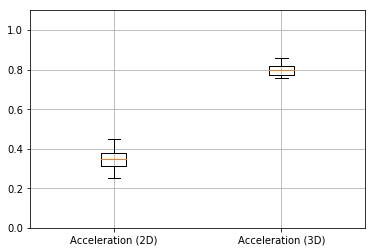

In [25]:
#ratio_vec60_05について箱ひげ図を作成（８月７日　追記）
import numpy as np
import matplotlib.pyplot as plt
hige = (ratio_mat[0,], ratio_mat[1,])

fig = plt.figure()
ax = fig.add_subplot(111)

# 箱ひげ図をつくる
bp = ax.boxplot(hige)
ax.set_xticklabels(['Acceleration (2D)', 'Acceleration (3D)'])

#plt.title('Box plot')
plt.grid()
#plt.xlabel('point')
#plt.ylabel('value')
#plt.title('Box plot')
plt.ylim([0,1.1])
plt.savefig("/home/okada/work/kekka/ShapeMove/acc_revise.png")
plt.show()